# Evap vs Bucket MSE
This notebook compares moist static energy on high quantile temperature days in two types of land simulation. One where land just has a reduced evaporative function and one that uses the bucket model.

In [1]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy, convection_neutral_profile
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn
from isca_tools.utils.constants import kappa, epsilon, L_v, c_p, g, R_v
from isca_tools.utils import area_weight_mean_lat, area_weighting
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm

2023-02-06 11:08:30,880 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [2]:
# Load dataset - one at surface and one in free troposphere
exp_dir = 'tau_sweep/land/meridional_band/'
land_method = ['evap', 'bucket']
var_keep = ['temp', 'sphum', 'height']        # only keep variables required to compute relative humidity and MSE
tau_lw_ref = 1
tau_lw_warm = 2
exp_names = [f'k={tau_lw_ref}', f'k={tau_lw_warm}']
exp_names.sort()
n_exp = len(exp_names)
ds = {'evap': [], 'bucket': []}
pressure_ft = 500       # Needs to be quite small as in bucket model, may not saturate
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    for method in land_method:
        ds_use = isca_tools.load_dataset(exp_dir + method + '/' + exp_names[i])[var_keep]
        ds[method] += [ds_use.sel(pfull=[pressure_ft, np.inf], method='nearest')]   # only keep at free trop and surface
    namelist = isca_tools.load_namelist(exp_dir + land_method[0] + '/' + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]

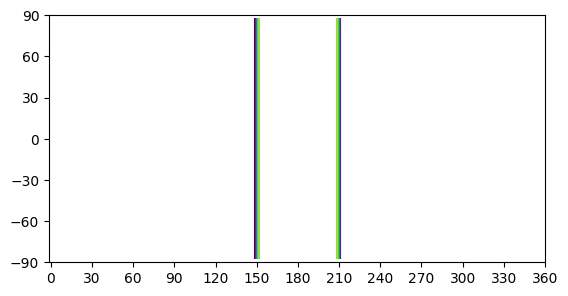

In [3]:
# Show where the land is
job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, land_method[0], exp_names[0], 'land.nc')
isca_tools.plot.show_land(land_file_name)

## Get datasets
Get one dataset, `ds_quant`, for land, for each latitude bin averaged over all days exceeding a given percentile in near surface air temperature.

Get another dataset, `ds_summer`, which is averaged over the ocean summer for a given latitude bin.

In [4]:
## Split datasets into land and ocean ones
ds_all = {'evap': {'land':[], 'ocean': []}, 'bucket': {'land':[], 'ocean': []}}
lon = {}
lon['land'] = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]
lon['ocean'] = isca_tools.utils.land.get_ocean_coords(land_file=land_file_name)[1]
for i in range(n_exp):
    for method in land_method:
        for surf in ['land', 'ocean']:
            ds_all[method][surf] += [ds[method][i].sel(lon=np.unique(lon[surf]), method='nearest')]

In [81]:
# Load in all temperatures and sphum for days above threshold temperature for given latitude bin
use_time_start = 360*2
# Tropics
lat_min = 0
lat_max = 20
# Extratropics
# lat_min = 30
# lat_max = 60

quantile_use = 95
temp_quant = {'evap': {'ocean':[], 'land': []}, 'bucket': {'ocean':[], 'land': []}}
sphum_quant = {'evap': {'ocean':[], 'land': []}, 'bucket': {'ocean':[], 'land': []}}
z_quant = {'evap': {'ocean':[], 'land': []}, 'bucket': {'ocean':[], 'land': []}}

temp_ft_quant = {'evap': {'ocean':[], 'land': []}, 'bucket': {'ocean':[], 'land': []}}
sphum_ft_quant = {'evap': {'ocean':[], 'land': []}, 'bucket': {'ocean':[], 'land': []}}
z_ft_quant = {'evap': {'ocean':[], 'land': []}, 'bucket': {'ocean':[], 'land': []}}
with tqdm(total=n_exp*2*2, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for method in land_method:
            for surf in ['ocean','land']:
                ds_use = ds_all[method][surf][i].sel(time=slice(use_time_start, np.inf))     # Only use after converged
                ds_use = ds_use.where((np.abs(ds_use.lat) <= lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)    # Only latitude region
                # Collapse to single coordinate and then take quantile over it
                ds_use = ds_use.stack(lon_lat_time=("lat","lon","time"), create_index=False).chunk(dict(lon_lat_time=-1))
                quantile_thresh = ds_use.temp[-1].quantile(quantile_use/100, dim='lon_lat_time', keep_attrs=True)   #[-1] for surface
                quant_ind = np.where(ds_use.temp[-1] > quantile_thresh)[0]

                temp_quant[method][surf] += [ds_use.temp[-1][quant_ind].to_numpy()]
                sphum_quant[method][surf] += [ds_use.sphum[-1][quant_ind].to_numpy()]
                z_quant[method][surf] += [ds_use.height[-1][quant_ind].to_numpy()]

                temp_ft_quant[method][surf] += [ds_use.temp[0][quant_ind].to_numpy()]
                sphum_ft_quant[method][surf] += [ds_use.sphum[0][quant_ind].to_numpy()]
                z_ft_quant[method][surf] += [ds_use.height[0][quant_ind].to_numpy()]
                pbar.update(1)

100%|██████████| 8/8 [01:54<00:00, 14.32s/it]


In [82]:
# Compute relative humidities from temp and surface humidities
p_surface = float(ds['evap'][0].pfull[-1]) * 100
rh_quant = {'evap': {'ocean':[], 'land': []}, 'bucket': {'ocean':[], 'land': []}}
for method in land_method:
    for surf in ['ocean', 'land']:
        for i in range(n_exp):
            rh_quant[method][surf] += [rh_from_sphum(sphum_quant[method][surf][i], temp_quant[method][surf][i], p_surface)]

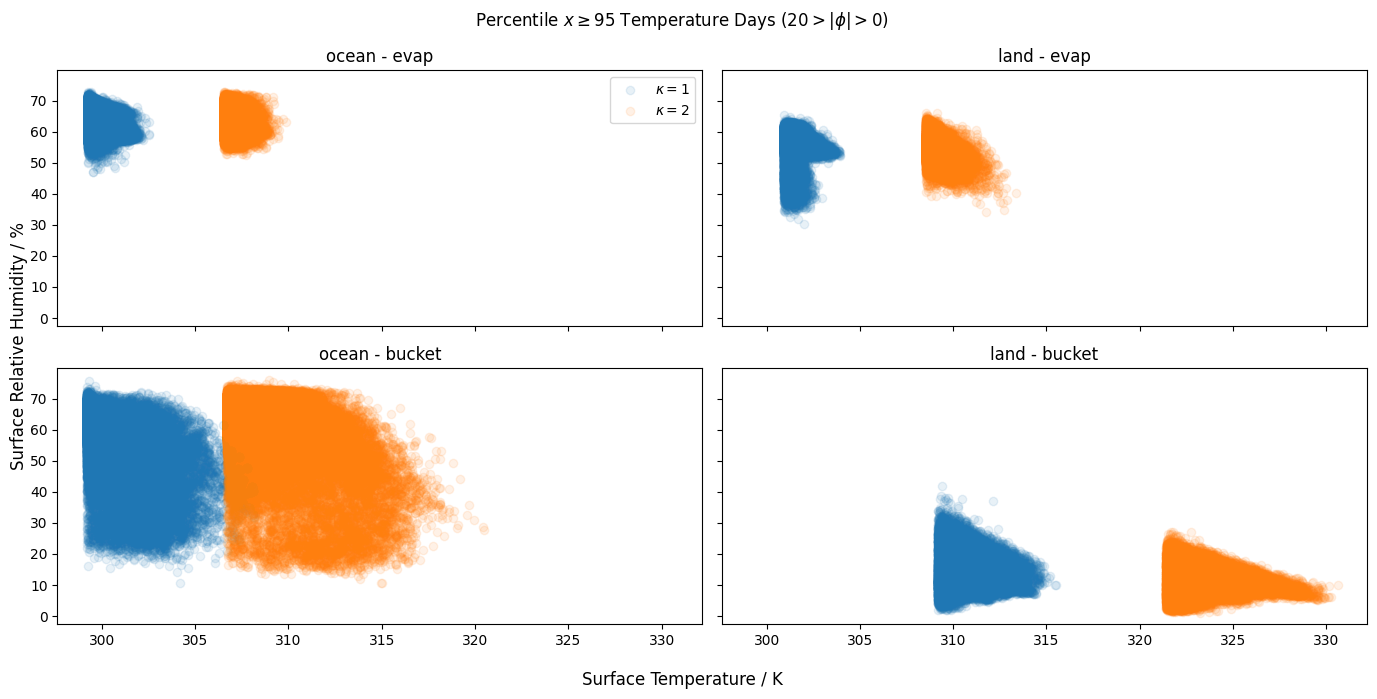

In [83]:
fig, ax = plt.subplots(2,2, figsize=(14, 7), sharex=True, sharey=True)
for i, method in enumerate(land_method):
    for k, surf in enumerate(['ocean', 'land']):
        for j in range(n_exp):
            ax[i, k].scatter(temp_quant[method][surf][j], rh_quant[method][surf][j], alpha=0.1, label=f'$\kappa = {tau_lw[j]}$')
            ax[i, k].set_title(f"{surf} - {method}")
ax[0, 0].legend()
fig.supxlabel('Surface Temperature / K')
fig.supylabel('Surface Relative Humidity / %')
fig.suptitle(f'Percentile $x \geq {quantile_use}$ Temperature Days (${lat_max} > |\phi| > {lat_min}$)')
fig.tight_layout();

The most striking thing from these plots is that the land is much drier (lower relative humidity) and warmer over land for the bucket model compared to the reduced evaporative fraction model.

From the plots above, it seems that the variance in temperature and relative humidity are much larger for the bucket model simulations than they are for the reduced evaporative fraction simulations, especially over ocean.

This may explain why when taking the average temperature profile across all days, in the bucket simulation, it differs from the convectively neutral profile more than for the evap simulations.

A better test for convective neutrality may be to compute the surface and free troposphere MSE on all days that exceed the threshold temperature and compare them. This is different from taking the average of all days and then computing the MSE from the resulting temperature profile.

## MSE
To check for convective neutrality, we want to check that $h = h^*_{FT}$ for a particular day, or equally: $\epsilon = h - h^*_{FT} = 0$.
Previously, we were computing the average MSE over all days exceeding the $x$ percentile day: $\epsilon_x = h_x - h^*_{x,FT}$.

But this would give a different result to computing $\epsilon = h - h^*_{FT}$ for each day and then taking the average of these. So below I compute $\epsilon$ for each high percentile day and plot their distribution for the different climates and land definitions.

In [84]:
# Compute MSE from surface and free troposphere saturated and compare them
# If convectively neutral, they should be the same
pressure_ft_actual = float(ds['evap'][0].pfull[0]) * 100     # This is the pressure level closest to pressure_ft

def mse_ft_sat(temp, height):
    # Calculate free troposphere saturated MSE for a given dataset in kJ/kg
    mix_ratio_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(temp), pressure_ft_actual)
    sphum_sat = mix_ratio_sat/(1+mix_ratio_sat)
    return moist_static_energy(temp, sphum_sat, height)

mse_surface = {'evap': {'ocean':[], 'land': []}, 'bucket': {'ocean':[], 'land': []}}
mse_ft = {'evap': {'ocean':[], 'land': []}, 'bucket': {'ocean':[], 'land': []}}

for method in land_method:
    for surf in ['ocean', 'land']:
        for i in range(n_exp):
            mse_surface[method][surf] += [moist_static_energy(temp_quant[method][surf][i],
                                                              sphum_quant[method][surf][i], z_quant[method][surf][i])]
            mse_ft[method][surf] += [mse_ft_sat(temp_ft_quant[method][surf][i], z_ft_quant[method][surf][i])]

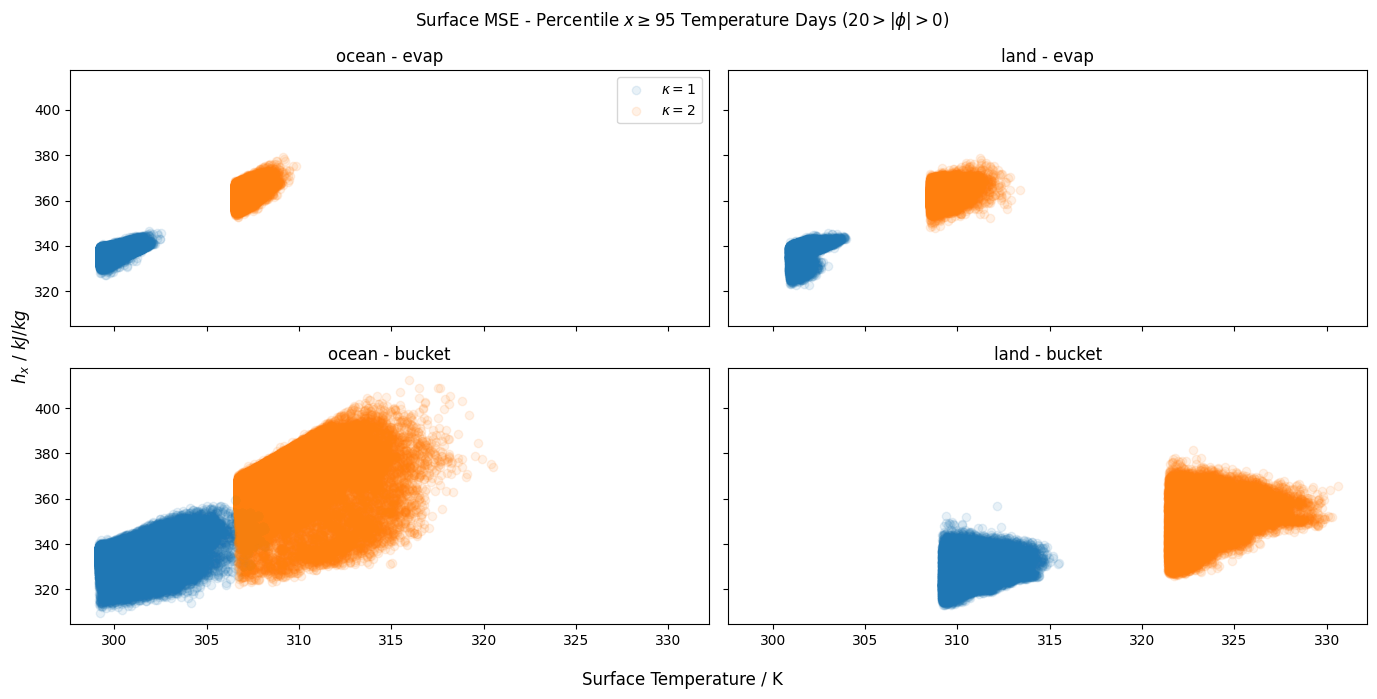

In [85]:
fig, ax = plt.subplots(2,2, figsize=(14, 7), sharex=True, sharey=True)
for i, method in enumerate(land_method):
    for k, surf in enumerate(['ocean', 'land']):
        for j in range(n_exp):
            ax[i, k].scatter(temp_quant[method][surf][j], mse_surface[method][surf][j], alpha=0.1, label=f'$\kappa = {tau_lw[j]}$')
            ax[i, k].set_title(f"{surf} - {method}")
ax[0, 0].legend()
fig.supxlabel('Surface Temperature / K')
fig.supylabel('$h_x$ / $kJ/kg$')
fig.suptitle(f'Surface MSE - Percentile $x \geq {quantile_use}$ Temperature Days (${lat_max} > |\phi| > {lat_min}$)')
fig.tight_layout();

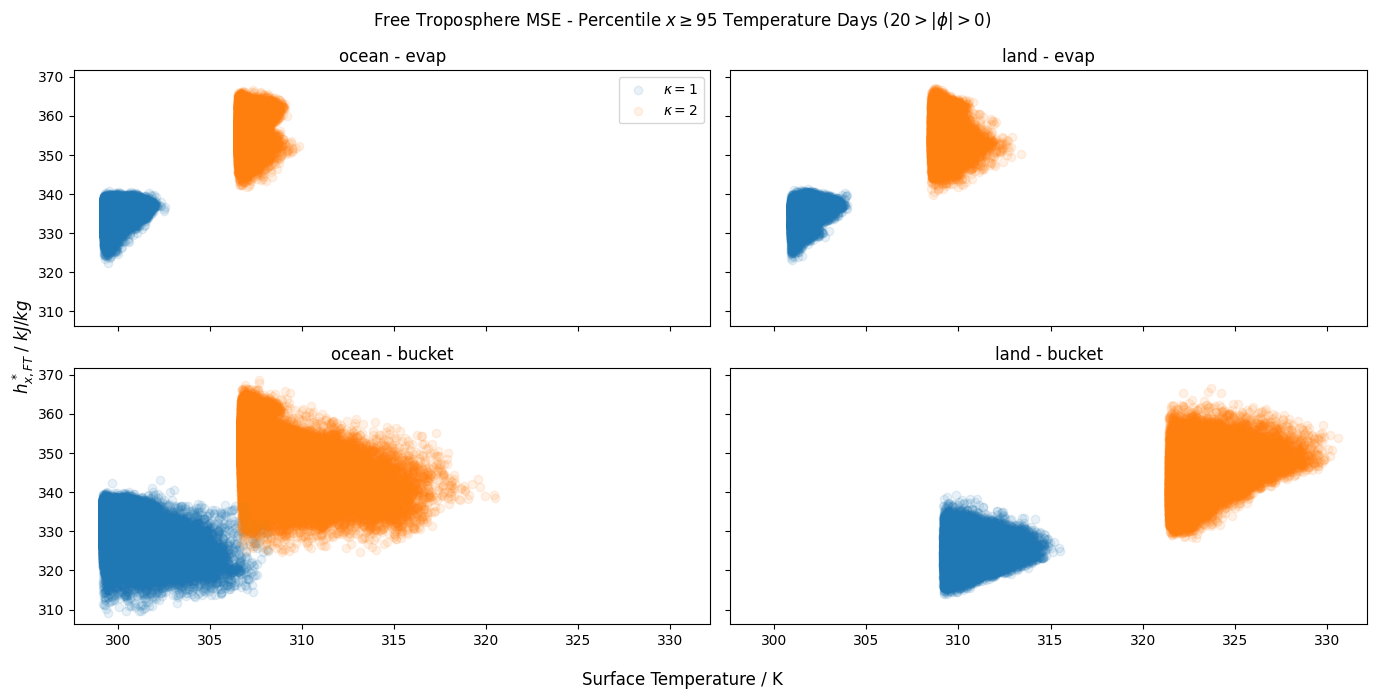

In [86]:
fig, ax = plt.subplots(2,2, figsize=(14, 7), sharex=True, sharey=True)
for i, method in enumerate(land_method):
    for k, surf in enumerate(['ocean', 'land']):
        for j in range(n_exp):
            ax[i, k].scatter(temp_quant[method][surf][j], mse_ft[method][surf][j], alpha=0.1, label=f'$\kappa = {tau_lw[j]}$')
            ax[i, k].set_title(f"{surf} - {method}")
ax[0, 0].legend()
fig.supxlabel('Surface Temperature / K')
fig.supylabel('$h^*_{x, FT}$ / $kJ/kg$')
fig.suptitle(f'Free Troposphere MSE - Percentile $x \geq {quantile_use}$ Temperature Days (${lat_max} > |\phi| > {lat_min}$)')
fig.tight_layout();

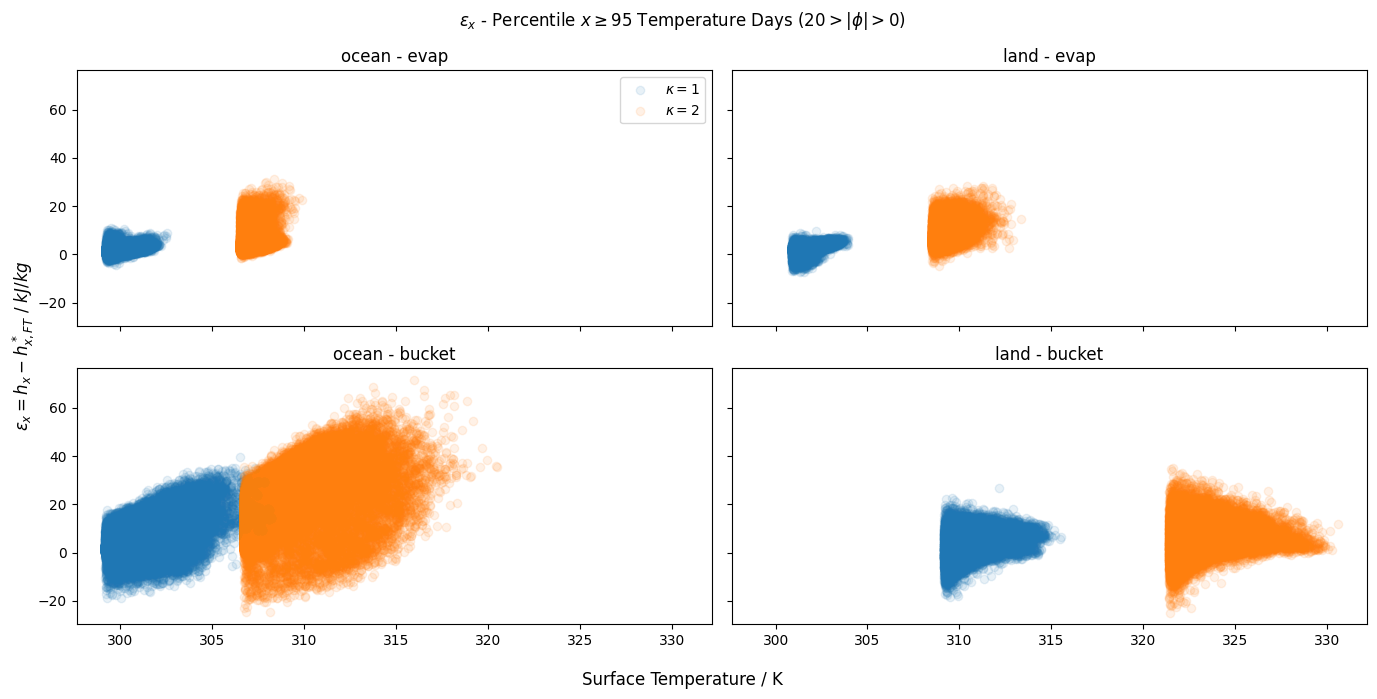

In [87]:
fig, ax = plt.subplots(2,2, figsize=(14, 7), sharex=True, sharey=True)
for i, method in enumerate(land_method):
    for k, surf in enumerate(['ocean', 'land']):
        for j in range(n_exp):
            ax[i, k].scatter(temp_quant[method][surf][j], mse_surface[method][surf][j] - mse_ft[method][surf][j],
                             alpha=0.1, label=f'$\kappa = {tau_lw[j]}$')
            ax[i, k].set_title(f"{surf} - {method}")
ax[0, 0].legend()
fig.supxlabel('Surface Temperature / K')
fig.supylabel('$\epsilon_x = h_x - h^*_{x, FT}$ / $kJ/kg$')
fig.suptitle(f'$\epsilon_x$ - Percentile $x \geq {quantile_use}$ Temperature Days (${lat_max} > |\phi| > {lat_min}$)')
fig.tight_layout();

### $\epsilon$ Histograms
The most striking thing from the [bucket simulations](https://github.com/jduffield65/Isca/blob/main/jobs/tau_sweep/land/meridional_band/bucket/temp_quant_theory_latitude.ipynb) is that over land in the extratropics, the change in $\epsilon$ with global warming ($\delta$) is much larger for the high quantile days than for the average summer ocean day.

The histograms below try to explain this.

In [88]:
## Get MSE avergaed over summer day datasets
temp_summer = {'evap': {'ocean':[], 'land': []}, 'bucket': {'ocean':[], 'land': []}}
sphum_summer = {'evap': {'ocean':[], 'land': []}, 'bucket': {'ocean':[], 'land': []}}
z_summer = {'evap': {'ocean':[], 'land': []}, 'bucket': {'ocean':[], 'land': []}}

temp_ft_summer = {'evap': {'ocean':[], 'land': []}, 'bucket': {'ocean':[], 'land': []}}
sphum_ft_summer = {'evap': {'ocean':[], 'land': []}, 'bucket': {'ocean':[], 'land': []}}
z_ft_summer = {'evap': {'ocean':[], 'land': []}, 'bucket': {'ocean':[], 'land': []}}

with tqdm(total=n_exp*2*2, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for method in land_method:
            for surf in ['ocean','land']:
                ds_use = ds_all[method][surf][i].sel(time=slice(use_time_start, np.inf))     # Only use after converged
                ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, [6, 7, 8]).sel(lat=slice(lat_min, lat_max))    # NH summer is JJA
                ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, [12, 1, 2]).sel(lat=slice(-lat_max, -lat_min))    # SH summer is DJF
                # Combine hemispheres and average over longitude, time and latitude.
                ds_use = xr.concat([ds_nh_summer, ds_sh_summer], dim='lat')
                ds_use = ds_use.stack(lon_lat_time=("lat","lon","time"), create_index=False).chunk(dict(lon_lat_time=-1))

                temp_summer[method][surf] += [ds_use.temp[-1].to_numpy()]
                sphum_summer[method][surf] += [ds_use.sphum[-1].to_numpy()]
                z_summer[method][surf] += [ds_use.height[-1].to_numpy()]

                temp_ft_summer[method][surf] += [ds_use.temp[0].to_numpy()]
                sphum_ft_summer[method][surf] += [ds_use.sphum[0].to_numpy()]
                z_ft_summer[method][surf] += [ds_use.height[0].to_numpy()]
                pbar.update(1)

100%|██████████| 8/8 [00:42<00:00,  5.36s/it]


In [89]:
# Compute MSE from surface and free troposphere saturated for summer and compare them
# If convectively neutral, they should be the same
mse_surface_summer = {'evap': {'ocean':[], 'land': []}, 'bucket': {'ocean':[], 'land': []}}
mse_ft_summer = {'evap': {'ocean':[], 'land': []}, 'bucket': {'ocean':[], 'land': []}}

for method in land_method:
    for surf in ['ocean', 'land']:
        for i in range(n_exp):
            mse_surface_summer[method][surf] += [moist_static_energy(temp_summer[method][surf][i],
                                                              sphum_summer[method][surf][i], z_summer[method][surf][i])]
            mse_ft_summer[method][surf] += [mse_ft_sat(temp_ft_summer[method][surf][i], z_ft_summer[method][surf][i])]

rh_summer = {'evap': {'ocean':[], 'land': []}, 'bucket': {'ocean':[], 'land': []}}
for method in land_method:
    for surf in ['ocean', 'land']:
        for i in range(n_exp):
            rh_summer[method][surf] += [rh_from_sphum(sphum_summer[method][surf][i], temp_summer[method][surf][i], p_surface)]

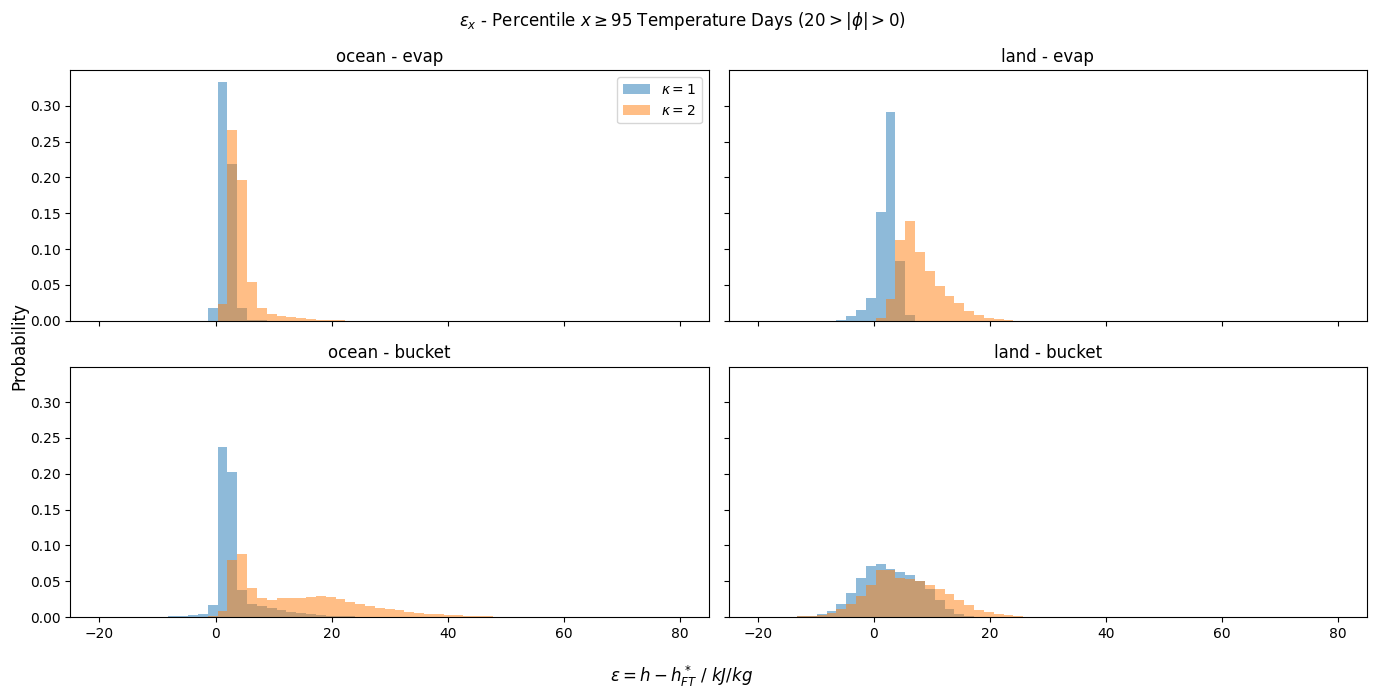

In [90]:
## Plot histograms of epsilon_x
fig, ax = plt.subplots(2,2, figsize=(14, 7), sharex=True, sharey=True)
for i, method in enumerate(land_method):
    for k, surf in enumerate(['ocean', 'land']):
        for j in range(n_exp):
            ax[i, k].hist(mse_surface[method][surf][j] - mse_ft[method][surf][j], label=f'$\kappa = {tau_lw[j]}$',
                          alpha=0.5, density=True, bins=np.linspace(-20, 80,60))
            ax[i, k].set_title(f"{surf} - {method}")
ax[0, 0].legend()
fig.supylabel('Probability')
fig.supxlabel('$\epsilon = h - h^*_{FT}$ / $kJ/kg$')
fig.suptitle(f'$\epsilon_x$ - Percentile $x \geq {quantile_use}$ Temperature Days (${lat_max} > |\phi| > {lat_min}$)')
fig.tight_layout();

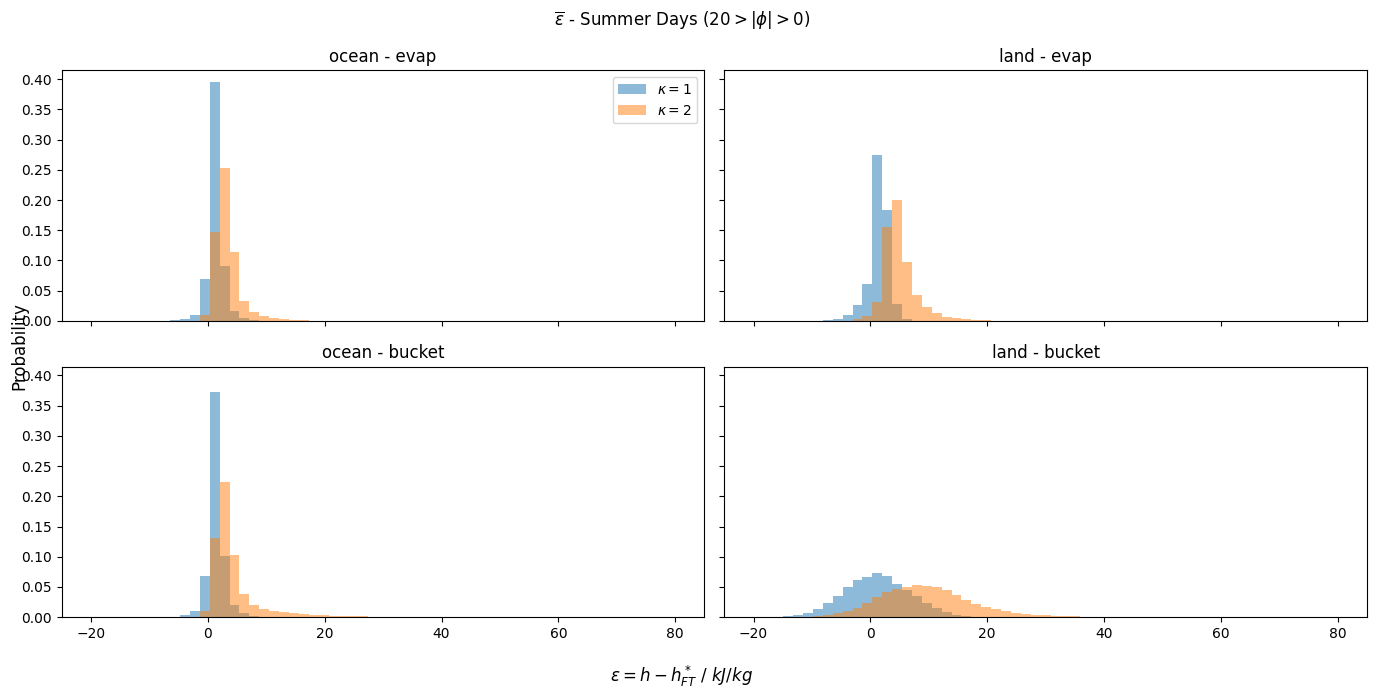

In [91]:
## Plot histograms of epsilon_x
fig, ax = plt.subplots(2,2, figsize=(14, 7), sharex=True, sharey=True)
for i, method in enumerate(land_method):
    for k, surf in enumerate(['ocean', 'land']):
        for j in range(n_exp):
            ax[i, k].hist(mse_surface_summer[method][surf][j] - mse_ft_summer[method][surf][j], label=f'$\kappa = {tau_lw[j]}$',
                          alpha=0.5, density=True, bins=np.linspace(-20, 80,60))
            ax[i, k].set_title(f"{surf} - {method}")
ax[0, 0].legend()
fig.supylabel('Probability')
fig.supxlabel('$\epsilon = h - h^*_{FT}$ / $kJ/kg$')
fig.suptitle('$\overline{\epsilon}$ - Summer Days ' +f'(${lat_max} > |\phi| > {lat_min}$)')
fig.tight_layout();

### Extratropics
Looking at the bucket histograms in the figure above, it is clear that the distribution shifts (from blue to orange) more for land than ocean. Also, from blue to orange there is a large increase in the tail of the distribution over land but not over ocean. This is reflected in the $\epsilon_x$ figure where the shift in the centre of the distribution is much larger over land than ocean i.e. $\delta \epsilon_x > \delta \overline{\epsilon}$ and this helps explain why Theory 4 underestimates the temperature change in the extratropics.

### Tropics
For the tropics, there is an increase in the tail of the distribution for the bucket simulations with global warming (blue to orange) for both the ocean and land simulations. Also, looking at the bottom right plot of the $\epsilon_x$ figure, we see that the shift in $\epsilon_x$ is smaller than the shift in $\overline{\epsilon}$ i.e. $\delta \epsilon_x < \delta \overline{\epsilon}$.

The plot below indicates there is a correlation between surface specific humidity and $\epsilon$.

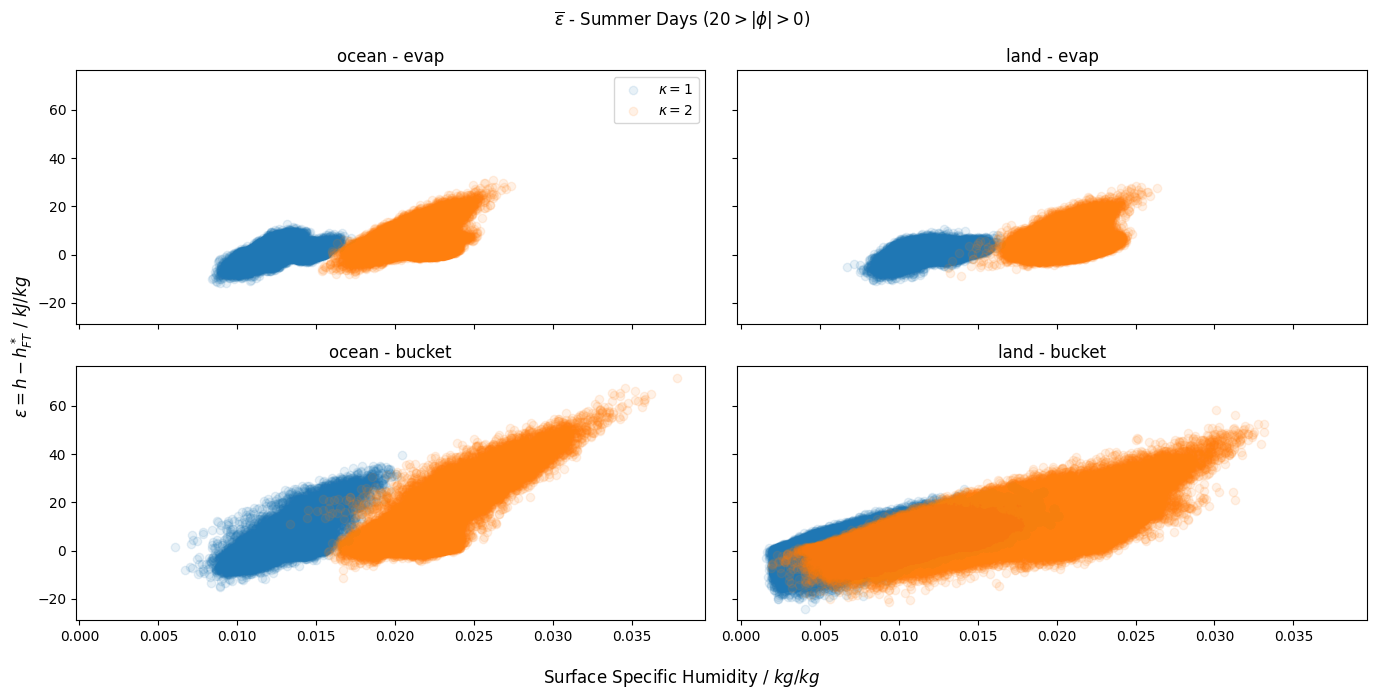

In [92]:
## Plot histograms of epsilon_x
fig, ax = plt.subplots(2,2, figsize=(14, 7), sharex=True, sharey=True)
for i, method in enumerate(land_method):
    for k, surf in enumerate(['ocean', 'land']):
        for j in range(n_exp):
            ax[i, k].scatter(sphum_summer[method][surf][j], mse_surface_summer[method][surf][j] - mse_ft_summer[method][surf][j],
                 alpha=0.1, label=f'$\kappa = {tau_lw[j]}$')
            ax[i, k].set_title(f"{surf} - {method}")
ax[0, 0].legend()
fig.supxlabel('Surface Specific Humidity / $kg/kg$')
fig.supylabel('$\epsilon = h - h^*_{FT}$ / $kJ/kg$')
fig.suptitle('$\overline{\epsilon}$ - Summer Days ' +f'(${lat_max} > |\phi| > {lat_min}$)')
fig.tight_layout();

### Relative Humidity
The plots below show how the relative humidity varies between the different land definitions. It is clear that with the bucket model, land has a completely different distribution, and much lower relative humidity than with the reduced evaporative fraction.

With global warming, the relative humidity on the hot (percentile $x$) land days decrease while the hot ocean days, mean land days and mean ocean days all increase in the tropics.

In the extratropics, the mean land day sees a decrease in relative humidity.

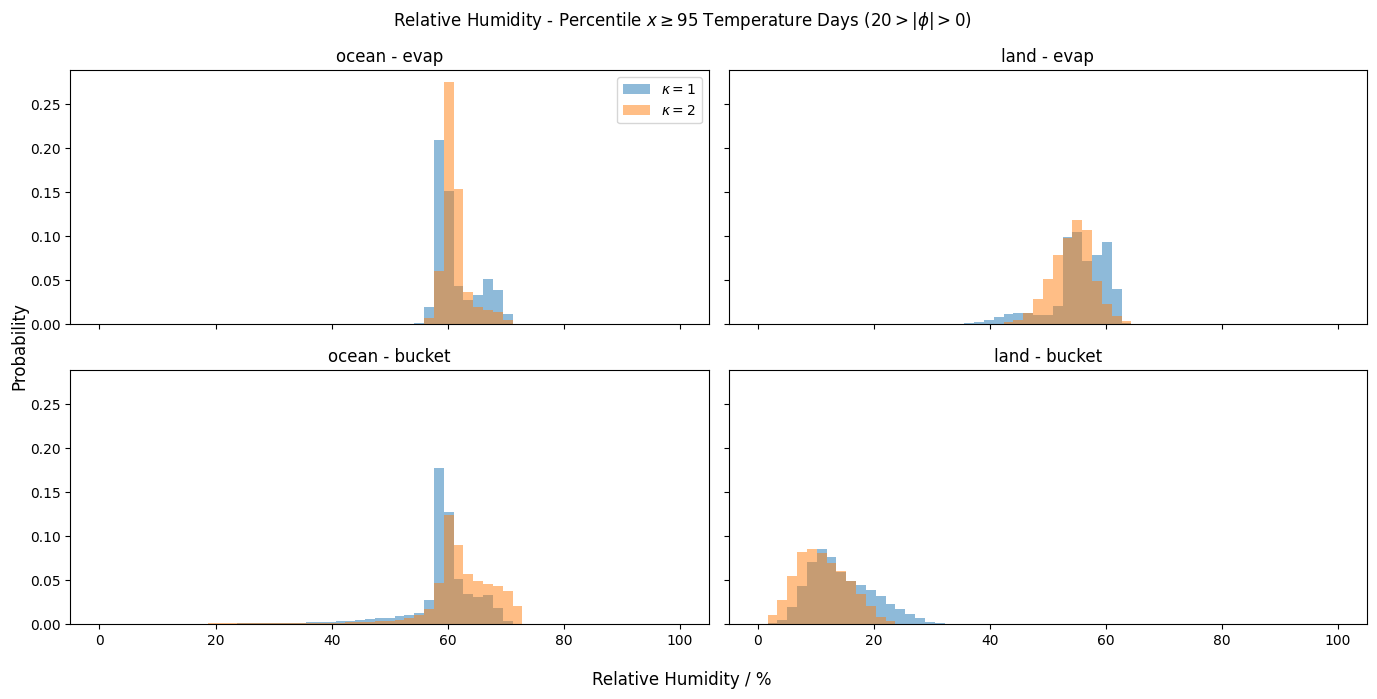

In [93]:
fig, ax = plt.subplots(2,2, figsize=(14, 7), sharex=True, sharey=True)
for i, method in enumerate(land_method):
    for k, surf in enumerate(['ocean', 'land']):
        for j in range(n_exp):
            ax[i, k].hist(rh_quant[method][surf][j], label=f'$\kappa = {tau_lw[j]}$',
                          alpha=0.5, density=True, bins=np.linspace(0, 100,60))
            ax[i, k].set_title(f"{surf} - {method}")
ax[0, 0].legend()
fig.supylabel('Probability')
fig.supxlabel('Relative Humidity / %')
fig.suptitle(f'Relative Humidity - Percentile $x \geq {quantile_use}$ Temperature Days (${lat_max} > |\phi| > {lat_min}$)')
fig.tight_layout();

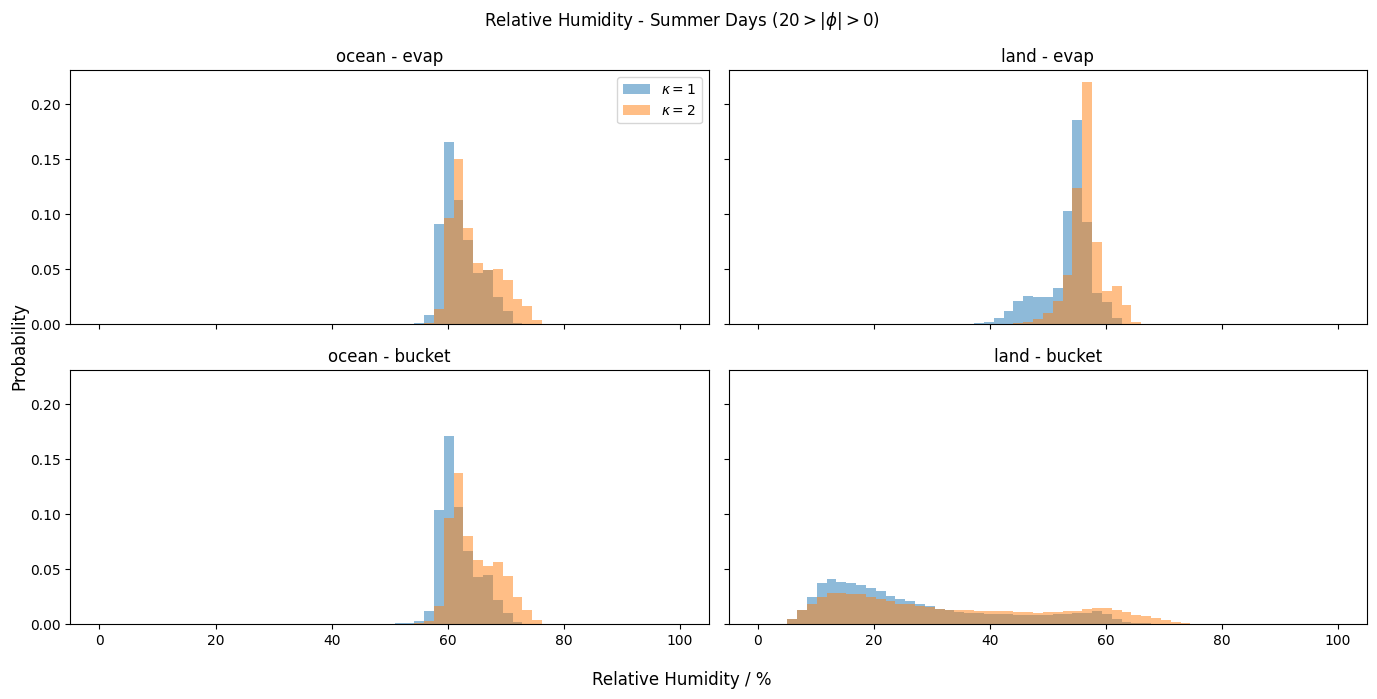

In [94]:
fig, ax = plt.subplots(2,2, figsize=(14, 7), sharex=True, sharey=True)
for i, method in enumerate(land_method):
    for k, surf in enumerate(['ocean', 'land']):
        for j in range(n_exp):
            ax[i, k].hist(rh_summer[method][surf][j], label=f'$\kappa = {tau_lw[j]}$',
                          alpha=0.5, density=True, bins=np.linspace(0, 100,60))
            ax[i, k].set_title(f"{surf} - {method}")
ax[0, 0].legend()
fig.supylabel('Probability')
fig.supxlabel('Relative Humidity / %')
fig.suptitle(f'Relative Humidity - Summer Days (${lat_max} > |\phi| > {lat_min}$)')
fig.tight_layout();